In [17]:
import os
import json
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from elasticsearch import Elasticsearch
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor, FeatureLogger
from tqdm import tqdm
import xgboost as xgb
from pprint import pprint

tqdm.pandas()

# Load environment variables from .env file
load_dotenv()

# Elasticsearch configuration
ELASTICSEARCH_HOST = os.getenv("ELASTICSEARCH_HOST", "localhost")
ELASTICSEARCH_PORT = int(os.getenv("ELASTICSEARCH_PORT", "9200"))
ELASTICSEARCH_USERNAME = os.getenv("ELASTICSEARCH_USERNAME")
ELASTICSEARCH_PASSWORD = os.getenv("ELASTICSEARCH_PASSWORD")

# Initialize Elasticsearch client
es_client = Elasticsearch(
    hosts=[{"host": ELASTICSEARCH_HOST, "port": ELASTICSEARCH_PORT, "scheme": "http"}],
    basic_auth=(ELASTICSEARCH_USERNAME, ELASTICSEARCH_PASSWORD)
)

index_name = "anime"

# Define LTR model configuration
ltr_config = LTRModelConfig(
    feature_extractors=[
        QueryFeatureExtractor(feature_name="title_bm25", query={"match": {"title": "{{query}}"}}),
        QueryFeatureExtractor(feature_name="synopsis_bm25", query={"match": {"synopsis": "{{query}}"}}),
        QueryFeatureExtractor(feature_name="phrase_match_title", query={"match_phrase": {"title": "{{query}}"}}),
        QueryFeatureExtractor(feature_name="phrase_match_synopsis", query={"match_phrase": {"synopsis": "{{query}}"}}),
        QueryFeatureExtractor(feature_name="match_synopsis_and", query={"match": {"title": {"query": "{{query}}", "operator": "and"}}}),
        QueryFeatureExtractor(feature_name="bm25_genre", query={"match": {"genres": "{{query}}"}})
    ]
)

# Initialize FeatureLogger
feature_logger = FeatureLogger(es_client, index_name, ltr_config)

def to_named_query(query, query_name):
    return {"bool": {"must": query, "_name": query_name}}

def extract_query_features_without_docs(query_params):
    from elasticsearch._sync.client import _quote
    __path = f"/{_quote(index_name)}/_search/template"
    __query = {"include_named_queries_score": True}
    __headers = {"accept": "application/json", "content-type": "application/json"}

    query_extractors = feature_logger._model_config.query_feature_extractors
    queries = [to_named_query(extractor.query, extractor.feature_name) for extractor in query_extractors]

    fields_to_get = [
        "anime_id", "anime_url", "title", "synopsis", "main_pic", "type", 
        "source_type", "num_episodes", "status", "start_date", "end_date", 
        "season", "studios", "genres", "score", "pics"
    ]
    additional_features = ["score", "score_count", "score_rank"]
    feat_names = [extractor.feature_name for extractor in query_extractors]

    source = json.dumps({
        "query": {"bool": {"should": queries}},
        "_source": fields_to_get + additional_features
    })

    __body = {"source": source, "params": {**query_params}}
    response = es_client.perform_request("GET", __path, params=__query, headers=__headers, body=__body)["hits"]["hits"]

    documents = {}
    animes_response = {}

    for hit in response:
        doc_id = hit['_source']['anime_id']
        dic_features = {
            feature: hit['matched_queries'][feature] if 'matched_queries' in hit and feature in hit['matched_queries'] else 0
            for feature in feat_names
        }
        animes_response[doc_id] = {field: hit['_source'][field] for field in fields_to_get}
        for feature in additional_features:
            dic_features[feature] = hit['_source'][feature]

        documents[doc_id] = dic_features

    df = pd.DataFrame.from_dict(documents, orient='index').reset_index().rename(columns={"index": "anime_id"})
    df2 = pd.DataFrame.from_dict(animes_response, orient='index').reset_index().rename(columns={"index": "anime_id"})

    return df, df2

# Load the XGBoost model
model_xgb = xgb.Booster()
model_xgb.load_model('anime_search_sdbn.txt')

# Extract features and anime details
features, animes = extract_query_features_without_docs({"query": "one puch"})
feature_names_to_predict = features.columns.drop('anime_id')

# Predict relevance scores
dmatrix = xgb.DMatrix(features[feature_names_to_predict])
y_pred = model_xgb.predict(dmatrix)

# Sort animes by relevance
animes['relevance'] = y_pred
animes = animes.sort_values(by='relevance', ascending=False)

# Convert to JSON format
animes_json = animes.to_dict(orient='records')
pprint(animes_json)


[{'anime_id': 30276,
  'anime_url': 'https://myanimelist.net/anime/30276/One_Punch_Man',
  'end_date': '2015-12-21T00:00:00',
  'genres': 'Action|Comedy|Sci-Fi|Supernatural|Parody|Super Power',
  'main_pic': 'https://cdn.myanimelist.net/images/anime/12/76049.jpg',
  'num_episodes': 12,
  'pics': 'https://cdn.myanimelist.net/images/anime/7/72533.jpg|https://cdn.myanimelist.net/images/anime/12/76049.jpg|https://cdn.myanimelist.net/images/anime/1536/91495.jpg',
  'relevance': 0.43485480546951294,
  'score': 8.49,
  'season': 'Fall 2015',
  'source_type': 'Web manga',
  'start_date': '2015-10-05T00:00:00',
  'status': 'Finished Airing',
  'studios': 'Madhouse',
  'synopsis': 'The seemingly unimpressive Saitama has a rather unique hobby: '
              'being a hero. In order to pursue his childhood dream, Saitama '
              'relentlessly trained for three years, losing all of his hair in '
              'the process. Now, Saitama is so powerful, he can defeat any '
              'ene

/tmp/ipykernel_80318/979988598.py:111: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  animes_json = animes.to_dict(orient='records')


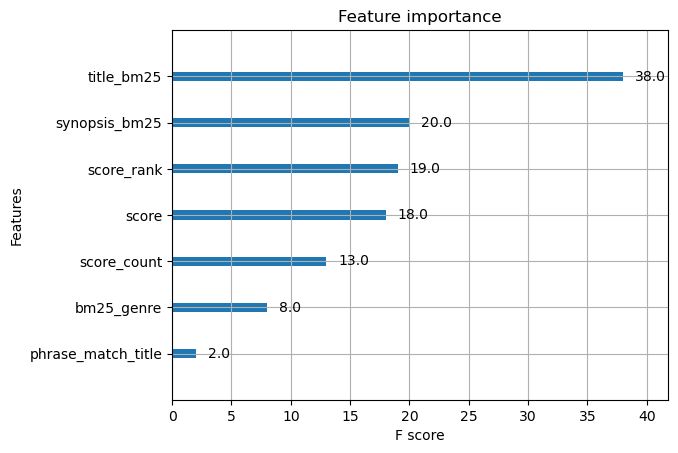

In [16]:
plot_importance(model_xgb, importance_type="weight");